In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd, numpy as np, os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML

font = {'size'   : 18}
matplotlib.rc('font', **font)

def plotHorizontalBars(series, xlabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.barh(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='x')
    plt.yticks(xpos, series.index)
    plt.xlabel(xlabel)
    plt.title(title)

def plotVerticalBars(series, ylabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.bar(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='y')
    plt.xticks(xpos, series.index)
    plt.ylabel(ylabel)
    plt.title(title)

In [3]:
import ssl, re
ssl._create_default_https_context = ssl._create_unverified_context
pd.__version__

'0.25.3'

In [4]:
# on Github, open CSV file and click on 'Raw'. Copy URL

filename = 'time_series_19-covid-Confirmed.csv'
data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+filename
ts_df = pd.read_csv(data_url)
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Diamond Princess', x) is not None)]
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Grand Princess', x) is not None)]
ts_df = ts_df.sort_values(['Country/Region', 'Province/State'])
print(ts_df['Country/Region'].unique())
display(ts_df)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Benin' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'Equatorial Guinea'
 'Estonia' 'Eswatini' 'Ethiopia' 'Finland' 'France' 'Gabon' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Greenland' 'Guatemala' 'Guernsey' 'Guinea'
 'Guyana' 'Holy See' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jersey'
 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kosovo' 'Kuwait' 'Latvia'
 'Lebanon' 'Liberia' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Malaysia'
 'Maldives' 'Malta' 'M

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
26,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4,4,5,7,7,7,11,16,21,22
95,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,2,10,12,23,33,38,42,51,55
29,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,19,20,20,20,24,26,37,48,54,60
60,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2,39
414,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,United Kingdom,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,273,321,382,456,456,798,1140,1140,1543,1950
416,NaN,Uruguay,-32.5228,-55.7658,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,8,29
442,NaN,Uzbekistan,41.3775,64.5853,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6,10
423,NaN,Venezuela,6.4238,-66.5897,0,0,0,0,0,0,...,0,0,0,0,0,0,2,10,17,33


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

lin_df = ts_df.drop(['Lat', 'Long', 'Province/State'], axis=1)
lin_df = lin_df.groupby('Country/Region').sum().transpose()
lin_df['date_count'] = [i for i in range(lin_df.shape[0])]
display(lin_df.tail(7))

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Central African Republic,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Dominican Republic,Ecuador,Egypt,Equatorial Guinea,Estonia,Eswatini,Ethiopia,Finland,France,Gabon,Georgia,Germany,Ghana,Greece,Greenland,Guatemala,Guernsey,Guinea,Guyana,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jersey,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Latvia,Lebanon,Liberia,Liechtenstein,Lithuania,Luxembourg,Malaysia,Maldives,Malta,Martinique,Mauritania,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Namibia,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Republic of the Congo,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Taiwan*,Tanzania,Thailand,The Bahamas,The Gambia,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,date_count
3/11/20,7,12,20,1,0,19,1,0,128,246,11,195,3,0,9,314,0,1,2,7,38,11,7,2,3,2,108,0,23,80921,9,0,1,13,1,19,0,6,91,444,5,17,60,0,16,0,0,59,2290,0,24,1908,0,99,0,0,0,0,0,1,2,13,85,62,34,9000,71,43,109,12462,1,639,0,1,0,0,7755,0,72,10,61,0,1,3,7,149,8,6,3,0,8,3,1,1,0,5,0,1,503,5,2,7,598,18,19,8,5,11,49,31,59,262,0,45,20,0,0,0,62,21,4,12,0,178,10,57,0,13,2277,2,0,0,500,652,48,0,59,0,0,1,0,7,1,1214,1,74,459,0,0,0,38,49
3/12/20,7,23,24,1,0,19,4,0,128,302,11,195,3,0,12,314,0,1,2,11,52,11,7,2,3,2,117,0,23,80932,9,0,1,22,1,19,3,6,94,617,5,17,67,0,16,0,0,59,2290,0,24,2078,0,99,0,0,0,0,1,1,2,13,103,73,34,10075,71,43,131,12462,2,639,0,1,0,0,7869,0,80,10,61,0,1,3,19,149,8,6,3,0,12,3,2,1,0,6,0,1,503,5,2,7,702,18,20,11,5,15,52,49,59,262,0,49,28,0,0,0,69,45,4,19,0,178,16,89,0,17,2277,2,0,0,599,652,49,0,70,0,0,1,0,7,1,1596,1,85,459,0,0,0,39,50
3/13/20,7,33,26,1,1,31,8,2,200,504,15,189,3,0,27,559,0,1,3,13,151,37,23,2,5,2,191,0,43,80945,13,0,2,23,1,32,4,14,141,804,5,17,80,0,79,0,1,155,3678,0,25,3675,0,190,0,0,0,1,1,1,2,19,134,82,69,11364,101,90,161,17660,8,701,0,1,4,1,7979,0,80,17,77,0,1,6,34,197,9,12,3,0,12,6,2,1,0,7,0,1,804,5,2,14,996,19,28,27,6,28,64,68,112,320,0,89,45,0,0,0,80,86,10,35,0,200,32,141,0,24,5232,6,1,0,814,1139,50,0,75,0,0,1,0,16,5,2112,3,85,802,0,0,0,47,51
3/14/20,11,38,37,1,1,34,18,2,250,655,15,210,3,0,27,689,0,1,10,18,151,40,41,2,7,2,196,0,61,80977,22,0,2,26,1,38,4,26,189,836,11,28,109,0,115,1,1,225,4487,1,30,4585,3,228,0,1,1,1,1,1,2,30,156,102,96,12729,110,129,193,21157,8,773,2,1,6,1,8086,0,104,26,93,0,4,8,51,238,10,18,9,1,26,12,2,1,0,17,2,1,960,6,2,14,1090,19,31,36,6,38,111,103,169,337,0,123,59,1,1,1,80,103,10,46,2,212,44,181,0,38,6391,10,1,1,961,1359,53,0,82,0,0,1,2,18,5,2660,3,85,1144,4,0,2,53,52
3/15/20,16,42,48,1,1,45,26,2,297,860,23,214,5,0,27,886,0,1,10,24,162,50,51,3,7,2,250,1,74,81003,34,1,2,27,1,49,4,26,253,875,11,28,110,1,171,1,1,244,4523,1,33,5795,6,331,0,1,1,1,4,1,3,32,171,113,117,13938,116,129,251,24747,10,839,2,8,9,3,8162,2,112,30,110,0,4,12,59,428,13,21,9,1,41,23,2,1,0,28,2,1,1136,8,2,14,1221,22,53,43,6,43,140,119,245,401,0,131,63,1,2,1,101,103,24,48,2,226,54,219,0,51,7798,18,1,1,1022,2200,59,0,114,0,0,1,2,18,6,3432,3,98,1145,4,1,10,56,53
3/16/20,21,51,54,2,1,56,52,2,377,1018,15,214,8,0,36,1058,1,1,11,25,200,54,52,15,7,4,413,1,155,81033,54,1,2,35,1,57,4,33,298,932,11,37,150,1,205,1,5,277,6668,1,33,7272,6,331,1,2,1,1,4,1,6,39,180,119,134,14991,124,169,255,27980,10,825,2,17,10,3,8236,2,123,34,99,1,4,17,77,566,13,30,15,1,53,23,7,1,0,29,2,1,1414,8,2,18,1333,22,136,55,8,86,142,177,331,439,1,

In [6]:
log_df = lin_df.copy()
log_df[log_df == 0] = 1e-5
log_df = np.log(log_df)
log_df[log_df < 0.1] = 0.0
log_df.date_count = lin_df.date_count
display(log_df.head(4))

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Central African Republic,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Dominican Republic,Ecuador,Egypt,Equatorial Guinea,Estonia,Eswatini,Ethiopia,Finland,France,Gabon,Georgia,Germany,Ghana,Greece,Greenland,Guatemala,Guernsey,Guinea,Guyana,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jersey,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Latvia,Lebanon,Liberia,Liechtenstein,Lithuania,Luxembourg,Malaysia,Maldives,Malta,Martinique,Mauritania,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Namibia,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Republic of the Congo,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Taiwan*,Tanzania,Thailand,The Bahamas,The Gambia,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,date_count
1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.306275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.466145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.824374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,2
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.248504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.

Country/Region,date_count,US,Italy,"Korea, South",Germany,France,Iran
3/11/20,49,1214,12462,7755,1908,2290,9000
3/12/20,50,1596,12462,7869,2078,2290,10075
3/13/20,51,2112,17660,7979,3675,3678,11364
3/14/20,52,2660,21157,8086,4585,4487,12729
3/15/20,53,3432,24747,8162,5795,4523,13938
3/16/20,54,4565,27980,8236,7272,6668,14991
3/17/20,55,6353,31506,8320,9257,7699,16169


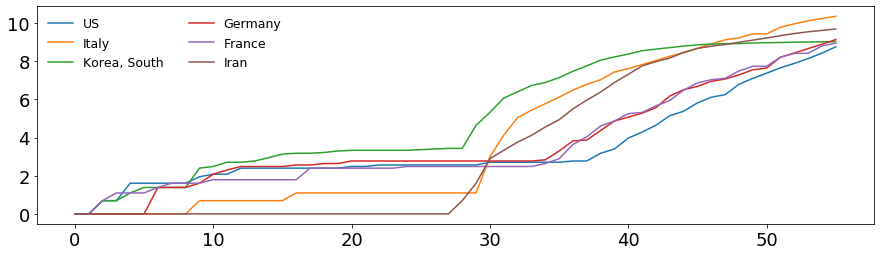

In [7]:
countries = ['Mainland China', 'US', 'Italy', 'Korea, South', 'Germany']
countries = ['US', 'Italy', 'Korea, South', 'Germany', 'France', 'Iran']
display(lin_df[['date_count'] + countries].tail(7))

fig, ax = plt.subplots(figsize=(15, 4))
for country in countries:
    ax.plot(log_df.date_count, log_df[country], label=country)
ax.legend(frameon=False, ncol=2, fontsize='x-small')

(19, 2)


Country/Region,date_count,US
2/28/20,37,16
2/29/20,38,24
3/1/20,39,30
3/2/20,40,53
3/3/20,41,73
3/4/20,42,104
3/5/20,43,172
3/6/20,44,217
3/7/20,45,336
3/8/20,46,452


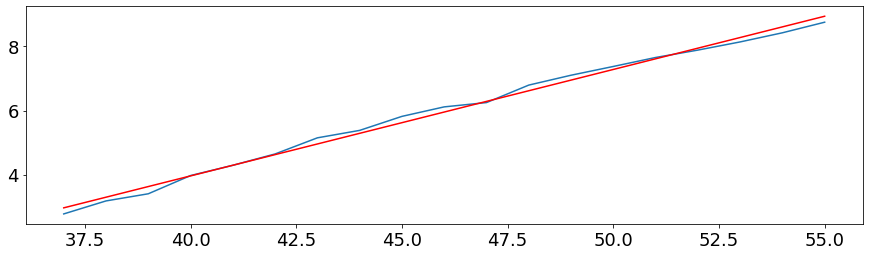

[[0.33225119]]


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

country = 'US'
df = lin_df[['date_count', country]].copy()
df = df[df.date_count >= 37]
#df = df.head(df.shape[0]-1)
print(df.shape)
display(df)

x = df.date_count.values.reshape(-1, 1)
y = df[country].values.reshape(-1, 1)
y = np.log(y)
lin_reg = LinearRegression()
lin_reg.fit(x, y)
y_fit = lin_reg.predict(x)

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()
print(lin_reg.coef_)

(19, 2)


Country/Region,date_count,US
2/28/20,37,16
2/29/20,38,24
3/1/20,39,30
3/2/20,40,53
3/3/20,41,73
3/4/20,42,104
3/5/20,43,172
3/6/20,44,217
3/7/20,45,336
3/8/20,46,452


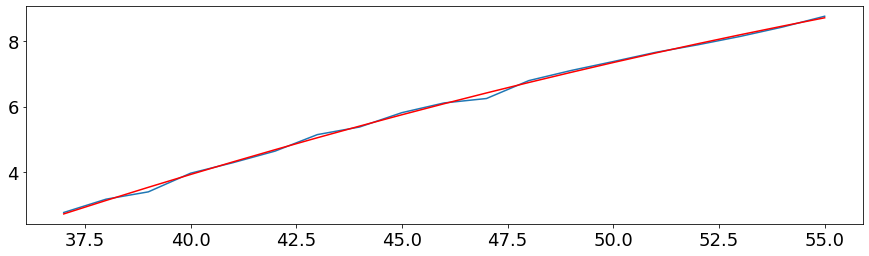

In [13]:
country = 'US'
df = lin_df[['date_count', country]].copy()
df = df[df.date_count >= 37]
#df = df.head(df.shape[0]-1)
print(df.shape)
display(df)

x = df.date_count.values.reshape(-1, 1)
x2 = x * x
y = df[country].values.reshape(-1, 1)
y = np.log(y)
qua_reg = LinearRegression()
qua_reg.fit(np.c_[x, x2], y)
y_fit = qua_reg.predict(np.c_[x, x2])

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()

In [16]:
regressor = qua_reg

x_fut = x.copy()
x_fut -= x.min()
x_fut += x.max()
if regressor == qua_reg:
    y_fut = regressor.predict(np.c_[x_fut, x_fut*x_fut])
else:
    y_fut = regressor.predict(x_fut)
print(y_fut)
y_fut = np.exp(y_fut)
mat = np.c_[x_fut, y_fut].astype(int)
print(mat)

[[ 8.70948644]
 [ 8.95480536]
 [ 9.19097351]
 [ 9.41799091]
 [ 9.63585753]
 [ 9.84457339]
 [10.04413849]
 [10.23455282]
 [10.41581639]
 [10.58792919]
 [10.75089123]
 [10.9047025 ]
 [11.04936301]
 [11.18487276]
 [11.31123173]
 [11.42843995]
 [11.5364974 ]
 [11.63540408]
 [11.72516   ]]
[[    55   6060]
 [    56   7745]
 [    57   9808]
 [    58  12307]
 [    59  15303]
 [    60  18855]
 [    61  23020]
 [    62  27849]
 [    63  33383]
 [    64  39653]
 [    65  46671]
 [    66  54431]
 [    67  62903]
 [    68  72032]
 [    69  81734]
 [    70  91898]
 [    71 102385]
 [    72 113029]
 [    73 123643]]
